# Regions

### © Luca de Alfaro, 2018-21, [CC-BY_NC License](http://creativecommons.org/licenses/by-nc-nd/4.0/).

In this module, we will write code to represent regions of space.  We will represent a _region_ as the union of rectangles whose sides are parallel to the Cartesian axes.  Of course, this does not suffice to represent all possible regions of space, but by using lots of small rectangles, we can at least approximate most (continuous, etc) regions.

Since a region is the union of rectangles, let us turn our attention to rectangles.

## Rectangles

We need to represent rectangles whose sides, and edges, are parallel to the axes of the Cartesian space.
What is a good representation for a rectangle?

Let us consider informally the 2D case first.
One of the most obvious representations for such a rectangle consists in representing it by its four vertices, represented as $(x, y)$ coordinate pairs.  The following is a possibility:

In [47]:
class NaiveRectangle1(object):

    def __init__(self, x0, y0, x1, y1, x2, y2, x3, y3):
        self.x0 = x0 # Lower left
        self.x1 = x1 # Upper left
        self.x2 = x2 # Upper right
        self.x3 = x3 # Lower right
        self.y0 = y0 # Lower left
        self.y1 = y1 # Upper left
        self.y2 = y2 # Upper right
        self.y3 = y3 # Lower right

This representation suffers from a first immediate problem: in a 2D rectangle with sides parallel to the edges, there are only 4 independent numbers, not 8!  In particular, we see that it must be `x0 == x3`, and `x1 == x2`, and `y0 == y1`, and `y2 = y3`.
This suggests keeping only the two opposite corners, for instance, lower left and upper right:

In [48]:
class NaiveRectangle2(object):

    def __init__(self, xll, yll, xur, yur):
        self.xll = x0 # Lower left
        self.yll = yll # Lower left
        self.xur = xur # Upper right
        self.yur = yur# Upper right


This representation, based on "selected vertices", is a plausible representation for 2D rectangles, but I argue not an optimal one.  There are two problems with it.

First, it is not clear how to generalize it to multiple dimensions.  In 3D, for instance, two vertices are not enough, four are too many, and yet, one can check that no set of three vertices of a rectangle suffices to uniquely identify the rectangle.  This lack of generalizability should make us suspicious that representing rectangles in terms of a reduced set of their vertices is not a good idea.

Second, even if we limit ourselves to 2D, the representation in terms of opposite vertices does not make it easy to implement the operations we need.  At a minimum, we need to compute operations between rectangles such as intersection and difference, so we can subtract boxes from the empty space.  Yet, there are many ways in which for example rectangles can intersect:

* One rectangle contains a vertex of the other.
* One rectangle is completely contained the other.
* One rectangle has a face in the other rectangle.

and perhaps more.  If we try to hard-code this for 3D rectangles, implementing operations such as intersection, and difference, might result in very cumbersome case analysis.  

Whenever things turn complicated, it is a good idea to wonder whether there is perhaps some other way of thinking at the problem, which is perhaps initially less apparent, but that can lead to a much simpler treatment.  In this case, there is: it is _intervals_.  

A 1D rectangle is simply an interval.  We can think of a 2D rectangle, rather than as a collection of vertices, as the intersection of two intervals: one for the x-axis, and one for the y-axis.  Similarly, a 3D rectangle can be thought of as the intersection of three intervals, on the x, y, and z axes.  To compute the intersection of two rectangles, we just need to compute the intersection of their intervals on the respective axes.  Thus, intervals provide a simple representation that generalizes well to multiple dimensions.

We start building our representation from intervals.  We then use intersection of intervals to represent rectangles, and unions rectangels to represent regions of space.


## Intervals

An interval is defined by its two endpoints.  We keep them sorted, which will make it (a lot) easier to operate on them.

In [49]:
class Interval(object):

    def __init__(self, x0, x1):
        # Sorts the endpoints, to ensure that x0 <= x1.
        x0, x1 = (x0, x1) if x0 < x1 else (x1, x0)
        assert x0 < x1 # No point intervals.
        self.x0 = x0
        self.x1 = x1

    @property
    def length(self):
        return self.x1 - self.x0

    def endpoints(self):
        return (self.x0, self.x1)

    def __getitem__(self, i):
        """Alternative way of accessing endpoints."""
        if i == 0:
            return self.x0
        elif i == 1:
            return self.x1
        raise KeyError()

    def __repr__(self):
        return "[{},{}]".format(self.x0, self.x1)

The main operations we need on intervals, to do anything interesting, are:

* **Intersection.** Given two intervals `i` and `j`, we want to define `__and__` for an interval so that `i && j` will be either `None`, if `i` and `j` have no intersection, or the interval corresponding to the intersection of `i` and `j`.

* **Union.** The union of two intervals is not necessarily an interval; it could also be _two_ intervals, if the original intervals are disjoint and there is a gap in between.  Thus, we define `__sub__` so that `i - j` returns a _list_ consisting of 1 or 2 intervals.

* **Difference.** The difference `i - j` is the portion of `i` that is not in `j`.  The result is a _list_ of intervals, containing 0 intervals (if `j` includes `i`), one interval (if `j` does not overlap `i`, or if it overlaps only from one side of `i`), or two intervals (if `j` falls in the middle of `i`).

* **Equality.** Two intervals are equal if, well, they are equal.

* **Membership.** We test for a point belonging to an interval.

In defining these operations, we disregard isolated points, and we blur the distinction between open and closed intervals.  After all, we only care about representing regions of space, and so isolated points and things that have no extension, or no volume, are not a concern of ours.  So for instance, if we subtract the interval $[3, 5]$ from $[0, 4]$, the result will be simply the interval $[4, 5]$: we do not track whether the interval is open or closed at 5.  Likewise, point-wise intervals such as $[5, 5]$ are simply not considered.

### Equality

Let us start by implementing equality.  We leave this to you.

In [50]:
#@title Defining Equality

def interval_equality(self, other):
    """Return True iff the intervals self and other are equal, and False otherwise."""
    # Remember, other is not guaranteed to be an Interval.
    if not isinstance(other, Interval):
        return False
    ### YOUR SOLUTION HERE
    return self.x0 == other.x0 and self.x1 == other.x1
Interval.__eq__ = interval_equality

In [51]:
i = Interval(3, 5)
j = Interval(4, 5)
i

[3,5]

In [52]:
# Tests 5 points.

assert i != j
assert Interval(5, 7) == Interval(5, 7)

### Union

We define union for you, to give you an example.

In [53]:
def interval_or(self, other):
    """Union of self and other.  Returns a list of 1 or 2 non-overlapping intervals."""
    if self.x1 < other.x0 or other.x1 < self.x0:
        # Disjoint
        return [self, other]
    else:
        # Have intersection, merge them.
        return [Interval(min(self.x0, other.x0), max(self.x1, other.x1))]

Interval.__or__ = interval_or

In [54]:
Interval(3, 5) | Interval(7, 10)

[[3,5], [7,10]]

In [55]:
Interval(3, 5) | Interval(4, 10)

[[3,10]]

## Intersection

The intersection of two intervals `i` and `j` consists either of a single interval, or `None`, if the two intervals have no intersection.  We leave it to you to implement it.

In [56]:
#@title Interval intersection

def interval_and(self, other):
    """Intersection; returns an interval, or None."""
    ### YOUR SOLUTION HERE
    if not isinstance(other, Interval):
      return None
    if self.x1 <= other.x0 or other.x1 <= self.x0:
        return None
    start = max(self.x0, other.x0)
    end = min(self.x1, other.x1)
    return Interval(start, end)
Interval.__and__ = interval_and

In [57]:
# Tests 10 points.

assert Interval(3, 10) & Interval(6, 20) == Interval(6, 10)
assert Interval(3, 4) & Interval(5, 6) is None

### Membership

Given an interval `i`, and a floating point number `x`, we can write a method `__contains__` of an interval, which checks if `x` belongs to the interval.  In this way, writing `x in i` will return `True` if `x` belongs to `i`, and `False` otherwise. For the purpose of this method, you can consider an interval closed, so that

    3 in Interval(3, 5)

returns `True`.

In [58]:
#@title Membership of a point in an interval

def interval_contains(self, x):
    ### YOUR SOLUTION HERE
    return self.x0 <= x <= self.x1
Interval.__contains__ = interval_contains

In [59]:
# Tests 10 points.

assert 3 in Interval(3, 5)
assert not (1 in Interval(3, 5))

## Difference

For intervals `i`, `j`, the difference of `i - j` consists of 0, 1, or 2 non-overlapping intervals.  Again, we leave the implementation to you.

In [60]:
#@title Interval difference

def interval_sub(self, other):
    """Subtracts from this interval the interval other, returning a possibly
    empty list of intervals."""
    ### YOUR SOLUTION HERE
    if not isinstance(other, Interval):
        return [self]

    #no overlap
    if self.x1 <= other.x0 or other.x1 <= self.x0:
        return [self]

    result = []

    #if other starts after  beginning
    if other.x0 > self.x0:
        result.append(Interval(self.x0, other.x0))

    #if other ends before
    if other.x1 < self.x1:
        result.append(Interval(other.x1, self.x1))

    return result
Interval.__sub__ = interval_sub

In [61]:
# Tests 10 points.

assert Interval(4, 6) - Interval(5, 8) == [Interval(4, 5)]
assert Interval(0, 10) - Interval(4, 5) == [Interval(0, 4), Interval(5, 10)]

The obvious problem with this implementation is that intervals are not closed under union or difference: the union of two intervals cannot be expressed as a single interval.  To obtain a type that is closed under union and difference, we should consider _unions of intervals_ instead.  The only reason we do not do it here is that intervals are only a temporary stepping stone for us to the definition of rectangles and regions, and so, we do not find it worthwhile to define a class that is closed under these operations.  The class Region, on the other hand, will be closed under these operations.

**Exercise:** Define an IntervalSet class, consisting of (finite!) unions of intervals, and define the union, difference, intersection, and len (total length) operations for it.

Another way of testing this code is the following.  Let's generate many random intervals $I_1$ and $I_2$.  Denoting with $-$ the difference of intervals and with $\cap$ their intersection, and denoting the length of an interval $I$ by $l(I)$, the following invariant must be true:

$$
l(I_1 - I_2) + l(I_2 - I_1) + 2l(I_1 \cap I_2) = l(I_1) + l(I_2)
$$

To verify this, let us start by defining this total length function precisely.


In [62]:
import numpy as np

def total_length(x):
    if x is None:
        return 0.
    elif type(x) == list:
        return np.sum([i.length for i in x])
    else:
        return x.length

print(total_length(None))
i1 = Interval(0, 1)
i2 = Interval(3, 5)
print("i1:", total_length(i1))
print("i2:", total_length(i2))
print("i1+i2:", total_length([i1, i2]))

0.0
i1: 1
i2: 2
i1+i2: 3


In [63]:
import random

def test_random():
    i1 = Interval(random.random(), random.random())
    i2 = Interval(random.random(), random.random())
    d1 = i1 - i2
    d2 = i2 - i1
    inters = i1 & i2
    assert (total_length(d1) + total_length(d2) + 2. * total_length(inters)
        == i1.length + i2.length)

for _ in range(100):
    test_random()


### Rectangles

Let us now develop a representation of a rectangle, in terms of intersection of intervals.  We will phrase the definition in such a way that it works in any number of dimensions, storing the intervals as a list, as opposed to (say) storing the three intervals separately for 3D.

In [64]:
import string

class Rectangle(object):

    def __init__(self, *intervals, name=None):
        """A rectangle is initialized with a list, whose elements are
        either Interval, or a pair of numbers.
        It would be perhaps cleaner to accept only list of intervals,
        but specifying rectangles via a list of pairs, with each pair
        defining an interval, makes for a concise shorthand that will be
        useful in tests.
        Every rectangle has a name, used to depict it.
        If no name is provided, we invent a random one."""
        self.intervals = []
        for i in intervals:
            self.intervals.append(i if type(i) == Interval else Interval(*i))
        # I want each rectangle to have a name.
        if name is None:
            self.name = ''.join(
                random.choices(string.ascii_letters + string.digits, k=8))
        else:
            self.name = name

    def __repr__(self):
        """Function used to print a rectangle."""
        s = "Rectangle " + self.name + ": "
        s += repr([(i.x0, i.x1) for i in self.intervals])
        return s

    def clone(self, name=None):
        """Returns a clone of itself, with a given name."""
        name = name or self.name + "'"
        return Rectangle(*self.intervals, name=name)

    def __len__(self):
        """Returns the number of dimensions of the rectangle
        (not the length of the edges).  This is used with
        __getitem__ below, to get the interval along a dimension."""
        return len(self.intervals)

    def __getitem__(self, n):
        """Returns the interval along the n-th dimension"""
        return self.intervals[n]

    def __setitem__(self, n, i):
        """Sets the interval along the n-th dimension to be i"""
        self.intervals[n] = i

    def __eq__(self, other):
        if not isinstance(other, Rectangle):
            return False
        # We rely on interval equality here.
        return self.intervals == other.intervals

    @property
    def ndims(self):
        """Returns the number of dimensions of the interval."""
        return len(self.intervals)

    @property
    def volume(self):
        return np.prod([i.length for i in self.intervals])



In [65]:
print(Rectangle(Interval(3., 4.), Interval(1., 4.)))
r = Rectangle(Interval(1., 2.), (5., 6.), name="my_rectangle")
print(r)
print(r.clone())

Rectangle 656rwtLN: [(3.0, 4.0), (1.0, 4.0)]
Rectangle my_rectangle: [(1.0, 2.0), (5.0, 6.0)]
Rectangle my_rectangle': [(1.0, 2.0), (5.0, 6.0)]


### Drawing rectangles

Before we go much further, it is useful to be able to draw rectangles.  Rectangles can have any number of dimensions, and we will write here code to draw them on 2D, projecting away all other dimensions.

In [66]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

def draw_rectangles(*rectangles, prefix=""):
    """Here, rectangles is a rectangle iterator; it could be a list,
    for instance."""
    fig, ax = plt.subplots()
    patches = []
    # We keep track of the limits.
    lo_x, hi_x = [], []
    lo_y, hi_y = [], []
    for r in rectangles:
        x0, x1 = r[0].endpoints()
        y0, y1 = r[1].endpoints()
        lo_x.append(x0)
        hi_x.append(x1)
        lo_y.append(y0)
        hi_y.append(y1)
        # Prepares the "patch" for the rectangle, see
        # https://matplotlib.org/api/_as_gen/matplotlib.patches.Rectangle.html
        p = mpatches.Rectangle((x0, y0), x1 - x0, y1 - y0)
        y = (y0 + y1) / 2. - 0.0
        x = (x0 + x1) / 2. - 0.0
        plt.text(x, y, prefix + r.name, ha="center", family='sans-serif', size=12)
        patches.append(p)
    # Draws the patches.
    colors = np.linspace(0, 1, len(patches) + 1)
    collection = PatchCollection(patches, cmap=plt.cm.hsv, alpha=0.3)
    collection.set_array(np.array(colors))
    ax.add_collection(collection)
    # Computes nice ax limits. Note that I need to take care of the case
    # in which the rectangle lists are empty.
    lox, hix = (min(lo_x), max(hi_x)) if len(lo_x) > 0 else (0., 1.)
    loy, hiy = (min(lo_y), max(hi_y)) if len(lo_y) > 0 else (0., 1.)
    sx, sy = hix - lox, hiy - loy
    lox -= 0.2 * sx
    hix += 0.2 * sx
    loy -= 0.2 * sy
    hiy += 0.2 * sy
    ax.set_xlim(lox, hix)
    ax.set_ylim(loy, hiy)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid()
    plt.show()


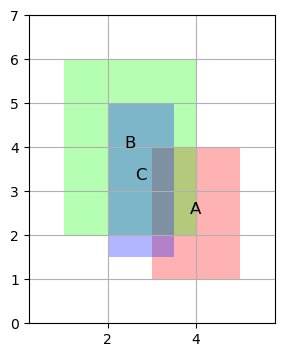

In [67]:
r1 = Rectangle((3., 5.), (1., 4.), name="A")
r2 = Rectangle((1., 4.), (2., 6.), name="B")
r3 = Rectangle((2., 3.5), (1.5, 5.), name="C")
draw_rectangles(r1, r2, r3)

### Rectangle Operations

There are three main operations on rectangles: intersection, union, and difference.
Among them, only intersection is guaranteed to return another rectangle.  In general, the union of two rectangles is ... two rectangles, and the difference between two rectangles is ... a whole lot of rectangles, as we will see.

We let you implement rectangle intersection.  Of course, the intersection is defined only if the rectangles have the same number of dimensions.  The intersection is computed by taking the intersection of the intervals of the two rectangles for corresponding dimensions.  If one of the intervals is empty, you should return None.  

In [68]:
# @ title Rectangle intersection

def rectangle_and(self, other):
    if self.ndims != other.ndims:
        raise TypeError("The rectangles have different dimensions: {} and {}".format(
            self.ndims, other.ndims
        ))
    ### YOUR SOLUTION HERE
    intersections = [self[i] & other[i] for i in range(self.ndims)]

    if any(interval is None for interval in intersections):
        return None

    return Rectangle(*intersections)

Rectangle.__and__ = rectangle_and

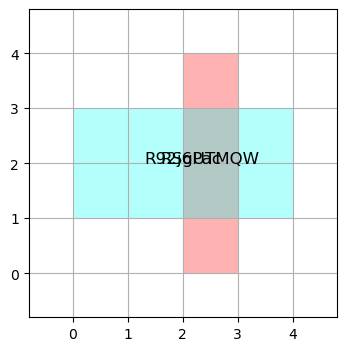

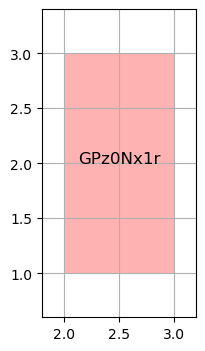

In [69]:
r1 = Rectangle((2, 3), (0, 4))
r2 = Rectangle((0, 4), (1, 3))
draw_rectangles(r1, r2)
draw_rectangles(r1 & r2)

In [70]:
# Tests 10 points.

r1 = Rectangle((12, 13), (0, 4))
r2 = Rectangle((0, 4), (1, 3))

assert r1 & r2 is None

In [71]:
#@title Membership of a point in a rectangle.

def rectangle_contains(self, p):
    # The point is a tuple with one element per dimension of the rectangle.
    assert len(p) == self.ndims
    ### YOUR SOLUTION HERE
    return all(i.x0 <= p[dim] <= i.x1 for dim, i in enumerate(self.intervals))

Rectangle.__contains__ = rectangle_contains

In [72]:
# Tests 10 points.

assert (2, 3) in Rectangle((0, 4), (1, 5))
assert (2, 3) not in Rectangle((0, 4), (4, 5))

**Exercise:** Write a method `__eq__` such that `r1 == r2` is `True` iff the two rectangles are identical, and a method `__le__` such that `r1 <= r2` returns `True` iff `r1` is a subset of `r2`.

### Rectangle Difference

There are two ways of defining rectangle difference:

* _Largest-cover difference_, which returns the difference represented by rectangles that are as large as possible, and therefore may be overlapping.
* _Disjoint difference_, which returns rectangles that are disjoint.

### Largest-Cover Difference

Given two rectangles $R = (I_1, I_2, \ldots, I_n)$ and $T = (J_1, J_2, \ldots, J_n)$, their difference $R-T$ is the region $\alpha =\tilde{R} \setminus \tilde{T}$. We make the following observation: for a point to be in $R$ and not in $T$, all it takes is that in *one* of the dimensions $k$, it is in $I_k$, but not in $J_k$.

Based on this idea, we construct a representation of $\tilde{R} \setminus \tilde{T}$ as follows.  We initialize the list of result rectangles to be empty.  Then, we iterate over all dimensions $k = 1, 2, \ldots, n$, and for each dimension $k$, we construct rectangles with intervals $I_1, \ldots, I_{k-1}, I_k - J_k, I_{k+1}, \ldots, I_n$, where $I_k - J_k$ represents interval difference.  There can be 0, 1, or 2 intervals in $I_k - J_k$, and correspondingly, $I_1, \ldots, I_{k-1}, I_k - J_k, I_{k+1}, \ldots, I_n$ will consist of 0, 1, or 2 rectangles; we add all such rectangles to the result list.  Let's translate this idea into code.

In [73]:
#@title Implementation of largest-cover difference

def rectangle_difference(r, t):
    """Computes the rectangle difference r - t, and outputs the result
    as a list of rectangles."""
    assert len(r) == len(t), "Rectangles have different dimensions"
    ### YOUR SOLUTION HERE
    assert len(r) == len(t), "Rectangles have different dimensions"

    differences = []
    for dim in range(r.ndims):
        if r[dim].x1 <= t[dim].x0 or r[dim].x0 >= t[dim].x1:
            differences.append([r[dim]])
        else:
            diff_intervals = []
            if r[dim].x0 < t[dim].x0:
                diff_intervals.append(Interval(r[dim].x0, t[dim].x0))
            if r[dim].x1 > t[dim].x1:
                diff_intervals.append(Interval(t[dim].x1, r[dim].x1))
            differences.append(diff_intervals)

    possible_rectangles = []
    for combination in cartesian_product(differences):
        possible_rectangles.append(Rectangle(*combination))

    return possible_rectangles

def cartesian_product(lists):
    """Compute the Cartesian product of input lists."""
    product = [[]]
    for lst in lists:
        product = [x + [y] for x in product for y in lst]
    return product

In the above code, we notice how it paid off to encapsulate intervals in their own abstraction.  Now that we need to reason about rectangles, we do not need to get bogged down into complicated considerations of how to perform difference; the comparisons between endpoints are all done in the context of intervals, where it is easier to reason about them.  It is often the case that problems become easy, once you think at them in the appropriate context.  It is much easier to develop the code for the difference of intervals, as we have done, and then move on to difference of rectangles, rather than trying to write code for rectangle difference directly.  The result is also far more elegant.

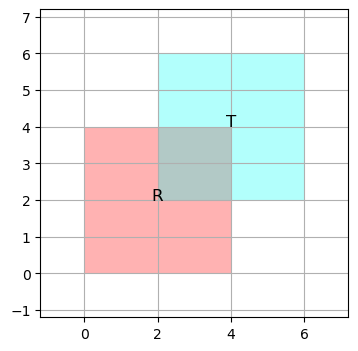

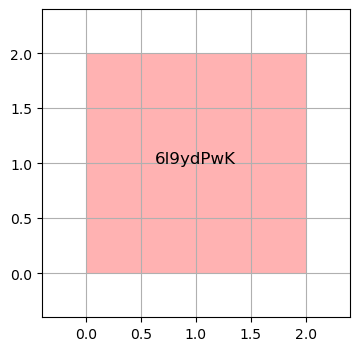

In [74]:
# Let us test visually what happens.
r = Rectangle((0., 4.), (0., 4.), name="R")
t = Rectangle((2., 6.), (2., 6.), name="T")
d = rectangle_difference(r, t)
draw_rectangles(r, t)
draw_rectangles(*d)

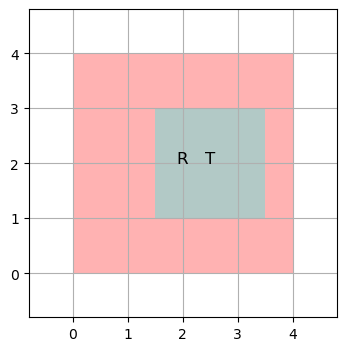

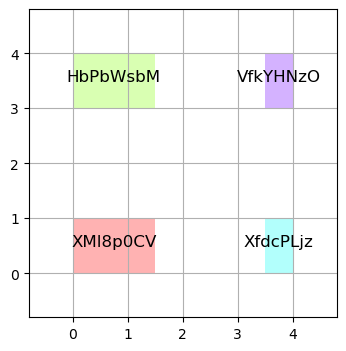

In [75]:
# Whooho!!  Let's try with another example. Now T is inside R.
r = Rectangle((0., 4.), (0., 4.), name="R")
t = Rectangle((1.5, 3.5), (1., 3.), name="T")
d = rectangle_difference(r, t)
draw_rectangles(r, t)
draw_rectangles(*d)

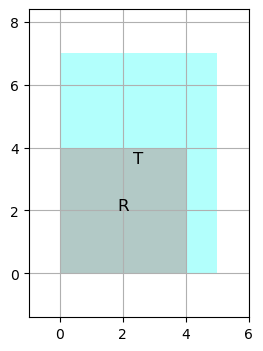

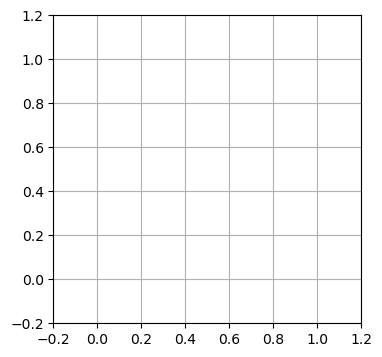

In [76]:
# It seems to work. And what happens if nothing is left?
r = Rectangle((0., 4.), (0., 4.), name="R")
t = Rectangle((0., 5.), (0., 7.), name="T")
d = rectangle_difference(r, t)
draw_rectangles(r, t)
draw_rectangles(*d)

#### Disjoint difference

We can also define a version of rectangle difference which returns a set of _disjoint_ rectangles.  The idea is this.  Let the two rectangles be $R = (I_1, \ldots, I_n)$ and $S = (J_1, \ldots, J_n)$, where $I_1, \ldots, I_n$ and $J_1, \ldots, J_n$ are the intervals forming the two rectangles $R$ and $S$.

To compute the difference $R \setminus S$ as a list of disjoint rectangles, we reason by induction (thus writing a recursive solution). Consider the coordinate $k = 1$.

Let $I_1 - J_1 = A$, so that $A$ is a list consisting of 0, 1, or 2 intervals.  Clearly, for any interval $L \in A$, we have that $(L, I_2, \ldots, I_n)$ is part of the result.

As for the remaining part of the result, let $I_1 \cap J_1 = H$.
$H$ can be empty, or consist of one interval.  
The rest of the result is given by

$$
(H, I_2, \ldots, I_n) \setminus (J_1, J_2, \ldots, J_n)
=
H \times [(I_2, \ldots, I_n) \setminus (J_2, \ldots, J_n)] \; .
$$

It is easier thus to define a generator, which yields all the rectangles in the difference.

In [77]:
#@title Computation of disjoint difference

def disjoint_minus(r, s):
    """R and S are equal-length lists of intervals, representing
    two rectangles R and S.  The function returns, or better, yields,
    all the rectangles in the disjoint difference of R and S."""
    ### YOUR SOLUTION HERE
    assert len(r) == len(s), "Interval lists have different dimensions"
    differences = [r[dim] - s[dim] for dim in range(len(r))]
    def cartesian_product(remaining_lists):
        if not remaining_lists:
            yield []
            return
        for item in remaining_lists[0]:
            for rest in cartesian_product(remaining_lists[1:]):
                yield [item] + rest

    for combination in cartesian_product(differences):
        yield combination

def disjoint_difference(self, other):
    return [Rectangle(*intervals) for intervals in disjoint_minus(self.intervals, other.intervals)]

[Rectangle HHmEAQCc: [(0.0, 1.5), (0.0, 1.0)], Rectangle DvERdmnH: [(0.0, 1.5), (3.0, 4.0)], Rectangle 2Oi69v0Y: [(3.5, 4.0), (0.0, 1.0)], Rectangle fEsJ0xfo: [(3.5, 4.0), (3.0, 4.0)]]


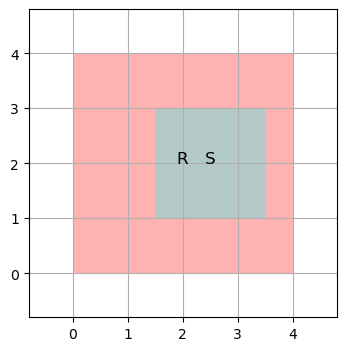

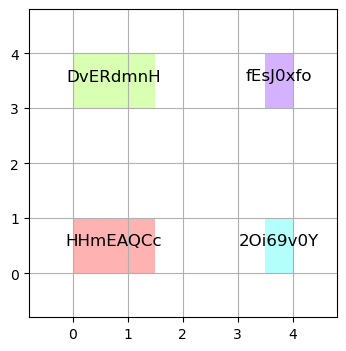

In [78]:
r = Rectangle((0., 4.), (0., 4.), name="R")
t = Rectangle((1.5, 3.5), (1., 3.), name="S")
d = disjoint_difference(r, t)
print(d)
draw_rectangles(r, t)
draw_rectangles(*d)

## Regions

The problem with rectangles is that they are not closed under union: the union of two rectangles is not necessarily a rectangle.  

We want a representation for objects in space that is closed under union, intersection, and difference.
To this end, we introduce _regions_, which are unions of rectangles.


In [79]:
class Region(object):

    def __init__(self, *rectangles, name=None):
        """A region is initialized via a set of rectangles."""
        assert len(rectangles) > 0, "A region requires at least one rectangle."
        self.ndims = rectangles[0].ndims
        for r in rectangles[1:]:
            assert r.ndims == self.ndims, "The rectangles do not all have the same dimensions!"
        self.rectangles = list(rectangles)
        if name is None:
            self.name = ''.join(
                random.choices(string.ascii_letters + string.digits, k=8))
        else:
            self.name = name

    def draw(self):
        draw_rectangles(*self.rectangles, prefix=self.name + ":")

    def __or__(self, other):
        """Union of regions."""
        return Region(*(self.rectangles + other.rectangles), name=self.name + "_union_" + other.name)

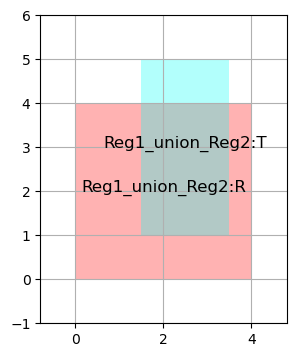

In [80]:
# Let us try.
r = Rectangle((0., 4.), (0., 4.), name="R")
t = Rectangle((1.5, 3.5), (1., 5.), name="T")

reg1 = Region(r, name="Reg1")
reg2 = Region(t, name="Reg2")

(reg1 | reg2).draw()

## Exercises

**Exercise**: Write a method `__and__` that computes the region representing the intersection of two regions.

**Exercise:** Write a method `__contains__`, which checks whether a n-dimensional point belongs to the region.  Remember, a point belongs to the region if it belongs to one of the rectangles in the region.

In [81]:
#@title Membership of a point in a region

def region_contains(self, p):
    ### YOUR SOLUTION HERE
  for rectangle in self.rectangles:
        if p in rectangle:
            return True
  return False

Region.__contains__ = region_contains

In [82]:
# Tests 10 points.

assert (2, 1) in Region(Rectangle((0, 2), (0, 3)), Rectangle((4, 6), (5, 8)))
assert (2, 1) not in Region(Rectangle((0, 1), (0, 3)), Rectangle((4, 6), (5, 8)))

**Exercise:** Write a method `__le__` for regions such that `R <= S` if the region `R` is contained in the region `S`.  You can test this by checking that the difference between R and S is empty.

**Excercise:** Write a subclass `NonoverlappingRegion` of `Region`, such that rectangles in `NonoverlappingRegion` are non-overlapping.  One should be able to create an object of class `NonoverlappingRegion` from any list of rectangles, and the initializer should use the method `disjoint_minus` to generate a list of non-overlapping rectangles defining the same region of space.  

## Monte-Carlo Methods

There are some obvious things we might want to do with a region, namely, compute its volume, compute whether two regions are equal, and compute the center of mass of a region.

There are two approaches to this.

One is to develop a precise approach.  The problem in computing the volume of a region is that the rectangles in it might overlap.  To solve this, one can use our method for computing disjoing differences to put regions in _normal form_, consisting of non-overlapping rectangles.
The idea is to keep a region as a list of non-overlapping rectangles.  When we add a rectangle $S$ from a region consisting of non-overlapping rectangles $R_1, \ldots, R_n$, we first subtract from $S$ each of $R_1, \ldots, R_n$ in turn, getting as result a bunch of subrectangles of $S$; we can then add these subrectangles to the region.

But this sounds like work!

An alternative is to develop a _randomized_ approach.

### A Monte-Carlo algorithm for region area

We can develop a randomized approach to measuring the area of a region as follows.  First, we compute a _bounding box_ around it, which is simply the smallest rectangle guaranteed to contain the region.  We simply take, for each coordinate, the min and max values of that coordinate of any rectangle in the region.

Once we have a bounding box $B$ for a region $\cal R$, we simply pick at random a lot of points $x \in B$, using our Python `random` function.   We can use our test $x \in \cal R$, written in code as `x in my_region`, to check whether a point $x$ belongs to region $\cal R$.  Let $N$ be the number of points we generate, and $M$ be the number of points that end up in $\cal R$.  The volume $V_{\cal R}$ of the region $\cal R$ can be simply written as:

$$
V_{\cal R} = \frac{M}{N} \cdot V_B \; ,
$$

where $V_B$ is the volume of the bounding box.  We will lead you to implement this code in steps.

This method is an example of a [Monte Carlo method](https://en.wikipedia.org/wiki/Monte_Carlo_method), a method which gives an answer to a question via repeated randomized experiments, rather than via mathematical computation, which may be complex or unfeasible.

### Bounding boxes

First, write a method `bounding_box` of a region, which returns the bounding box as a rectangle.

In [83]:
#@title Compute the bounding box of a region

def region_bounding_box(self):
    """Returns the bounding box of the region, as a rectangle.
    This returns None if the region does not contain any rectangle."""
    if len(self.rectangles) == 0:
        return None
    ### YOUR SOLUTION HERE
    bounding_intervals = [
        Interval(
            min(rect[dim].x0 for rect in self.rectangles),
            max(rect[dim].x1 for rect in self.rectangles)
        )
        for dim in range(self.ndims)
    ]

    return Rectangle(*bounding_intervals)
Region.bounding_box = property(region_bounding_box)

In [84]:
reg = Region(Rectangle((0, 2), (1, 3)), Rectangle((4, 6), (5, 8)))
reg.bounding_box

Rectangle G7LINehb: [(0, 6), (1, 8)]

### Select random points from a rectangle

Next, we write a Rectangle method `random_point`, which returns a point of a rectangle chosen uniformly at random each time it is called.  To this end, it is easier first to write the corresponding method for an interval.  [In Python](https://docs.python.org/3/library/random.html#real-valued-distributions),

    random.random()

returns a random value uniformly distributed between 0 and 1, and

    random.uniform(a, b)

returns a random value uniformly distributed between a and b.  We can use this to define the interval method:

In [85]:
import random

def interval_random_point(self):
    return random.uniform(self.x0, self.x1)

Interval.random_point = interval_random_point

# Or if we wanted to be concise, we could just have written:

Interval.random_point = lambda self : random.uniform(self.x0, self.x1)

To select a random point from a rectangle, we just need to return a tuple formed by choosing a random point from each of the rectangle's intervals.  We leave this to you.  Remember that the intervals of a rectangle `self` are in `self.intervals`.

In [86]:
#@title Random point of a rectangle

def rectangle_random_point(self):
    ### YOUR SOLUTION HERE
    return tuple(interval.random_point() for interval in self.intervals)
Rectangle.random_point = rectangle_random_point

In [87]:
r = Rectangle((0, 2), (1, 3))

for i in range(5):
    p = r.random_point()
    assert isinstance(p, tuple)
    assert len(p) == 2
    assert p in r
    print(p)

(0.8897477254160999, 2.307253579510478)
(0.20529241229765405, 2.078904666846888)
(1.6398196042164614, 2.4033932695102447)
(1.5149610464746512, 1.130166058118003)
(1.1797590887529732, 2.882336684806039)


We are now ready to compute the volume of a region $\cal R$ using Monte Carlo methods.  The form of your code is:

* Compute the bounding box $B$
* Pick $N$ points at random from $B$, and count the number $M$ of them that fall in $\cal R$.
* Return $B.volume \cdot (M/N)$.

In [88]:
#@title Monte carlo Volume

def region_montecarlo_volume(self, n=1000):
    """Computes the volume of a region, using Monte Carlo approximation
    with n samples."""
    # The solution, written without any particular trick, takes 7 lines.
    # If you write a much longer solution, you are on the wrong track.
    ### YOUR SOLUTION HERE
    bounding_box = self.bounding_box
    points_inside = sum(1 for _ in range(n) if bounding_box.random_point() in self)
    return (points_inside / n) * bounding_box.volume
Region.montecarlo_volume = region_montecarlo_volume

The approximation becomes the more precise, the more samples we have.

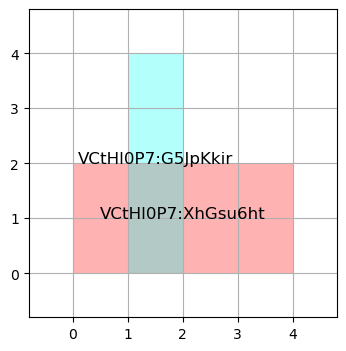

   10 samples: 9.6
  100 samples: 11.04
 1000 samples: 10.224
10000 samples: 10.0896


In [89]:
reg = Region(Rectangle((0, 4), (0, 2)), Rectangle((1, 2), (0, 4)))
reg.draw()
print("   10 samples:", reg.montecarlo_volume(n=10))
print("  100 samples:", reg.montecarlo_volume(n=100))
print(" 1000 samples:", reg.montecarlo_volume(n=1000))
print("10000 samples:", reg.montecarlo_volume(n=10000))

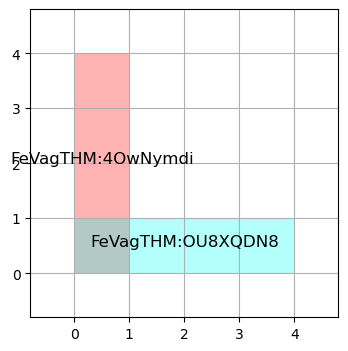

   10 samples: 9.6
  100 samples: 8.16
 1000 samples: 6.816
10000 samples: 7.0688


In [90]:
reg = Region(Rectangle((0, 1), (0, 4)), Rectangle((0, 4), (0, 1)))
reg.draw()
print("   10 samples:", reg.montecarlo_volume(n=10))
print("  100 samples:", reg.montecarlo_volume(n=100))
print(" 1000 samples:", reg.montecarlo_volume(n=1000))
print("10000 samples:", reg.montecarlo_volume(n=10000))

We could quantify the standard deviation of the result, but it is beyond the scope of this class.

**Exercise (BONUS 10pts):** Develop a Monte-Carlo method for computing the center of mass of a region.  The idea consists in sampling uniformly at random from the bounding box, retaining only the points that are in the region.  The center of mass of the sampled points in the region provides an approximation for the center of mass of the region.

## A Monte-Carlo method for region equality

We can apply Monte Carlo methods also to the question of deciding region equality.

One way to decide whether two regions $\cal R_1$ and $\cal R_2$ are equal consists in subtracting $\cal R_2$ from $\cal R_1$ and checking that the result is empty, and then subtracting $\cal R_1$ from $\cal R_2$, and checking that it is also empty.

But again, this sounds like work, and why work if we can just guess?

The idea is to compute the bounding box $B$ of $\cal R_1 \cup \cal R_2$, and to sample points from $B$.  If we find a point $p$ that belongs to one region but not the other, we declare the regions distinct.  If we do not find such "distinguishing" point after $N$ trials, we declare the regions identical, and the point serves as a witness to their difference.

We leave the implementation to you.

In [91]:
#@title Monte Carlo difference and equality between regions

def region_montecarlo_difference(self, other, n=1000):
    """Checks whether a region self is different from a region other, using
    a Monte Carlo method with n samples.  It returns either a point p that
    witnesses the difference of the regions, or None, if no such point is found."""
    # This can be done without hurry in 6 lines of code.
    ### YOUR SOLUTION HERE
    union_bounding_box = Region(*(self.rectangles + other.rectangles)).bounding_box
    for _ in range(n):
        point = union_bounding_box.random_point()
        if (point in self and point not in other) or (point in other and point not in self):
            return point
    return None
Region.montecarlo_difference = region_montecarlo_difference

def region_montecarlo_equality(self, other, n=1000):
    return self.montecarlo_difference(other, n=n) is None

Region.montecarlo_equality = region_montecarlo_equality

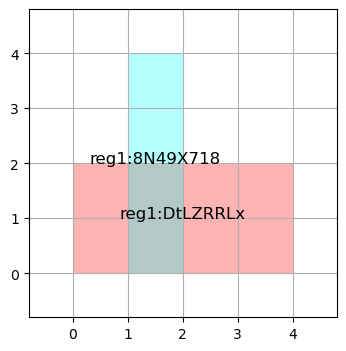

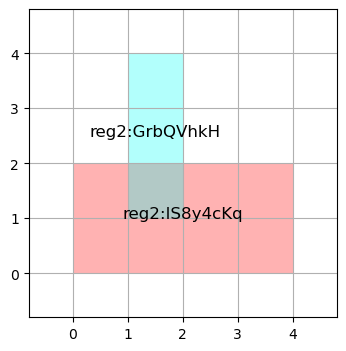

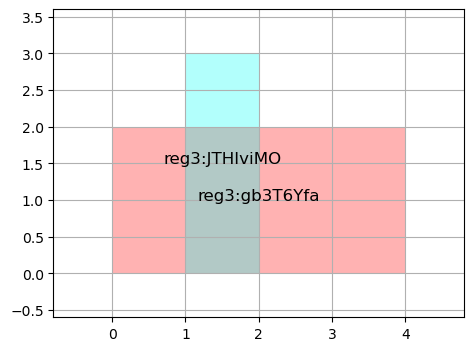

reg1 vs reg2 True
reg1 vs reg2 False
reg1 vs reg3 (1.3987302551045393, 3.3371365489050064)


In [92]:
reg1 = Region(Rectangle((0, 4), (0, 2)), Rectangle((1, 2), (0, 4)), name="reg1")
reg2 = Region(Rectangle((0, 4), (0, 2)), Rectangle((1, 2), (1, 4)), name="reg2")
reg3 = Region(Rectangle((0, 4), (0, 2)), Rectangle((1, 2), (0, 3)), name="reg3")
reg1.draw()
reg2.draw()
reg3.draw()
print("reg1 vs reg2", reg1.montecarlo_equality(reg2))
print("reg1 vs reg2", reg1.montecarlo_equality(reg3))
print("reg1 vs reg3", reg1.montecarlo_difference(reg3))
